In [15]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
hep.style.use("CMS")

file keys [b'tree;1']

ttree keys [b'numJetsParton', b'numJetsHadron', b'pTPartonJets', b'pTHadronJets', b'yPartonJets', b'yHadronJets', b'phiPartonJets', b'phiHadronJets']

tree["numJetsParton"] = <TBranch b'numJetsParton' at 0x7f0a7edd9650>

numJetsParton              (no streamer)              asdtype('>i4')
numJetsHadron              (no streamer)              asdtype('>i4')
pTPartonJets               (no streamer)              asdtype('>f8')
pTHadronJets               (no streamer)              asdtype('>f8')
yPartonJets                (no streamer)              asdtype('>f8')
yHadronJets                (no streamer)              asdtype('>f8')
phiPartonJets              (no streamer)              asdtype('>f8')
phiHadronJets              (no streamer)              asdtype('>f8')
tree.show() =  None
Partonpt= [ 0.         10.58716051 10.58716051 ... 10.35331239 10.35331239
 10.58120752]
Partonpt.shape= (184810,)
Hadrononpt.shape= (184810,)


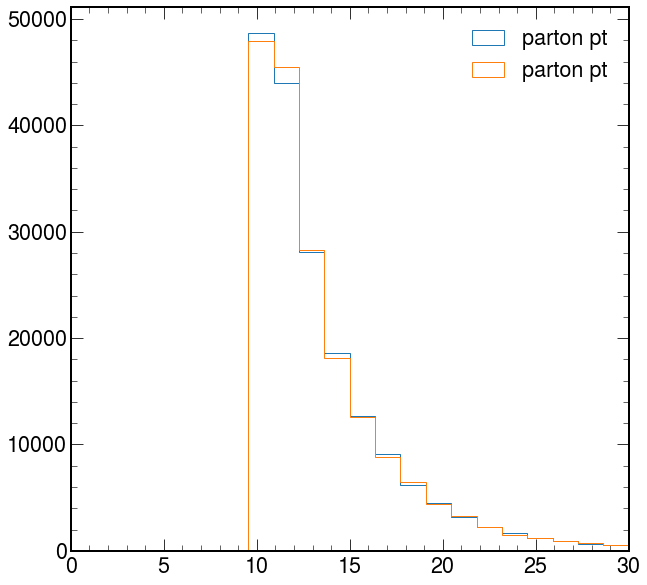





Partonptcounts =  [    1     0     0     0     0     0     0 48681 44028 28119 18613 12715
  9060  6221  4464  3173  2235  1706  1207   954   681   499]
PartonPartonptcounts.shape =  (22,)
Partonptbins =  [ 0.          1.36363636  2.72727273  4.09090909  5.45454545  6.81818182
  8.18181818  9.54545455 10.90909091 12.27272727 13.63636364 15.
 16.36363636 17.72727273 19.09090909 20.45454545 21.81818182 23.18181818
 24.54545455 25.90909091 27.27272727 28.63636364 30.        ]
Partonptbins.shape =  (23,)

Partonptcenters.shape = (22,)


NameError: name 'Hadronptcenters' is not defined

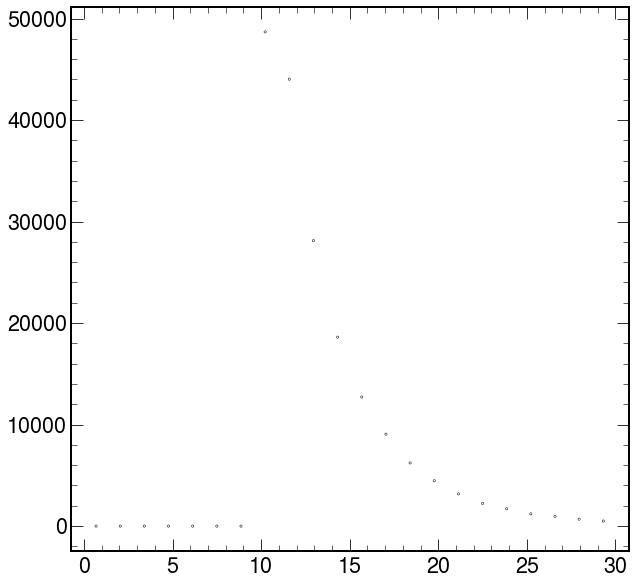

In [72]:
with uproot.open('Jetsoutput.root') as file:
    print('file keys', file.keys())
    tree = file["tree"]
    print()
    print('ttree keys',tree.keys())
    print()
    print('tree["numJetsParton"] =',tree["numJetsParton"])
    print()
    print('tree.show() = ', tree.show())
    # numJets = tree["numJetsParton"].array(library="np")
    Partonpt, Hadronpt = tree.arrays(["pTPartonJets","pTHadronJets"], outputtype = tuple)
    # pt_part = pt["pTPartonJets"]
    # pt_had = pt["pTHadronJets"]
    print('Partonpt=', Partonpt)
    print('Partonpt.shape=', Partonpt.shape)
    print('Hadrononpt.shape=', Hadronpt.shape)

    
    r=(0,30)
    b=22
    
    plt.xlim(r)
    plt.hist(Partonpt,bins=b, label='parton pt',range=r,histtype='step',rwidth=0.8)
    
    plt.hist(Hadronpt,bins=b, label='parton pt',range=r,histtype='step',rwidth=0.8)
    
    plt.legend()
    
    
    plt.show()
    
    print('\n\n\n')
    Partonptcounts, Partonptedges = np.histogram(Partonpt, bins=b, range=r)
    print('Partonptcounts = ', Partonptcounts)
    print('PartonPartonptcounts.shape = ', Partonptcounts.shape)
    
    
    Partonptcenters = (Partonptedges[1:]+Partonptedges[:-1])/2
    Hadronptcenters = (Hadronpt[1:]+Hadronptptedges[:-1])/2
    
    print('Partonptbins = ', Partonptbins)
    
    print('Partonptbins.shape = ', Partonptbins.shape)
    print('\nPartonptcenters.shape =' , Partonptcenters.shape)
    
    
    plt.scatter(Partonptcenters, Partonptcounts, label='parton bin centers',
            color="k",facecolors='none', marker="o", s=5, linewidth=0.5)
    
    plt.scatter(Hadronptcenters, Hadronptcounts, label='hadron bin centers', 
                color="k",facecolors='none', marker="o", s=5, linewidth=0.5)

In [54]:
np.histogram?


Signature:
np.histogram(
    a,
    bins=10,
    range=None,
    normed=None,
    weights=None,
    density=None,
)
Docstring:
Compute the histogram of a dataset.

Parameters
----------
a : array_like
    Input data. The histogram is computed over the flattened array.
bins : int or sequence of scalars or str, optional
    If `bins` is an int, it defines the number of equal-width
    bins in the given range (10, by default). If `bins` is a
    sequence, it defines a monotonically increasing array of bin edges,
    including the rightmost edge, allowing for non-uniform bin widths.

    .. versionadded:: 1.11.0

    If `bins` is a string, it defines the method used to calculate the
    optimal bin width, as defined by `histogram_bin_edges`.

range : (float, float), optional
    The lower and upper range of the bins.  If not provided, range
    is simply ``(a.min(), a.max())``.  Values outside the range are
    ignored. The first element of the range must be less than or
    equal to the s